In [1]:
import jax
import jax.numpy as jnp
import numpy as np # get rid of this eventually
import argparse
from jax import jit
from jax.experimental.ode import odeint
from functools import partial # reduces arguments to function by making some subset implicit

from jax.example_libraries import stax
from jax.experimental import optimizers

import os, sys, time
sys.path.append('..')

In [2]:
sys.path.append('../experiment_dblpend/')

from lnn import lagrangian_eom_rk4, lagrangian_eom, unconstrained_eom, raw_lagrangian_eom
from data import get_dataset
from models import mlp as make_mlp
from utils import wrap_coords

In [3]:
sys.path.append('../hyperopt')

In [4]:
from HyperparameterSearch import learned_dynamics

In [5]:
from HyperparameterSearch import extended_mlp

In [6]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

In [7]:
from data import get_trajectory

In [8]:
from data import get_trajectory_analytic

In [9]:
from physics import analytical_fn

vfnc = jax.jit(jax.vmap(analytical_fn))
vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxstep=100), (0, None), 0))

In [10]:
# 0.29830917716026306 {'act': [4],
# 'batch_size': [27.0], 'dt': [0.09609870774790222],
# 'hidden_dim': [596.0], 'l2reg': [0.24927677946969878],
# 'layers': [4.0], 'lr': [0.005516656601005163],
# 'lr2': [1.897157209816416e-05], 'n_updates': [4.0]}

### Now, let's load the best model. To generate more models, see the code below.

In [11]:
import pickle as pkl

In [12]:
# loaded = pkl.load(open('./params_for_loss_0.29429444670677185_nupdates=1.pkl', 'rb'))

In [13]:
args = ObjectView({'dataset_size': 200,
 'fps': 10,
 'samples': 100,
 'num_epochs': 80000,
 'seed': 0,
 'loss': 'l1',
 'act': 'softplus',
 'hidden_dim': 600,
 'output_dim': 1,
 'layers': 3,
 'n_updates': 1,
 'lr': 0.001,
 'lr2': 2e-05,
 'dt': 0.1,
 'model': 'gln',
 'batch_size': 512,
 'l2reg': 5.7e-07,
})
# args = loaded['args']
rng = jax.random.PRNGKey(args.seed)

In [14]:
from jax.experimental.ode import odeint

In [15]:
from HyperparameterSearch import new_get_dataset

In [16]:
from matplotlib import pyplot as plt

In [17]:
vfnc = jax.jit(jax.vmap(analytical_fn, 0, 0))
vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxstep=100), (0, None), 0))
minibatch_per = 2000
batch = 512

@jax.jit
def get_derivative_dataset(rng):
    # randomly sample inputs

    y0 = jnp.concatenate([
        jax.random.uniform(rng, (batch*minibatch_per, 2))*2.0*np.pi,
        (jax.random.uniform(rng+1, (batch*minibatch_per, 2))-0.5)*10*2
    ], axis=1)
    
    return y0, vfnc(y0)

In [18]:
best_params = None
best_loss = np.inf

In [19]:
from itertools import product

In [20]:
init_random_params, nn_forward_fn = extended_mlp(args)
import HyperparameterSearch
HyperparameterSearch.nn_forward_fn = nn_forward_fn
_, init_params = init_random_params(rng+1, (-1, 4))
rng += 1
model = (nn_forward_fn, init_params)
opt_init, opt_update, get_params = optimizers.adam(args.lr)
opt_state = opt_init([[l2/200.0 for l2 in l1] for l1 in init_params])
from jax.tree_util import tree_flatten
from HyperparameterSearch import make_loss, train
from copy import deepcopy as copy
# train(args, model, data, rng);
from jax.tree_util import tree_flatten

@jax.jit
def loss(params, batch, l2reg):
    state, targets = batch#_rk4
    leaves, _ = tree_flatten(params)
    l2_norm = sum(jnp.vdot(param, param) for param in leaves)
    preds = jax.vmap(
        partial(
            raw_lagrangian_eom,
            learned_dynamics(params)))(state)
    return jnp.sum(jnp.abs(preds - targets)) + l2reg*l2_norm/args.batch_size

# @jax.jit
# def normalize_param_update(param_update):
#     new_params = []
#     num_weights = args.hidden_dim**2*3
#     gradient_norm = sum([jnp.sum(l2**2)
#                          for l1 in param_update
#                          for l2 in l1
#                          if len(l1) != 0])/num_weights
# #     gradient_norm = 1 + 
#     for l1 in param_update:
#         if (len(l1)) == 0: new_params.append(()); continue
#         new_l1 = []
#         for l2 in l1:
#             new_l1.append(
#                 l2/gradient_norm
#             )

#         new_params.append(new_l1)
        
#     return new_params

@jax.jit
def update_derivative(i, opt_state, batch, l2reg):
    params = get_params(opt_state)
    param_update = jax.grad(
            lambda *args: loss(*args)/len(batch),
            0
        )(params, batch, l2reg)
#     param_update = normalize_param_update(param_update)
    params = get_params(opt_state)
    return opt_update(i, param_update, opt_state), params


best_small_loss = np.inf
(nn_forward_fn, init_params) = model
iteration = 0
total_epochs = 300
minibatch_per = 2000
train_losses, test_losses = [], []

lr = 1e-5 #1e-3
import math

final_div_factor=1e4

#OneCycleLR:
@jax.jit
def OneCycleLR(pct):
    #Rush it:
    start = 0.2 #0.2
    pct = pct * (1-start) + start
    high, low = lr, lr/final_div_factor
    
    scale = 1.0 - (jnp.cos(2 * jnp.pi * pct) + 1)/2
    
    return low + (high - low)*scale
    
from lnn import custom_init

opt_init, opt_update, get_params = optimizers.adam(
    OneCycleLR
)

init_params = custom_init(init_params, seed=0)

opt_state = opt_init(init_params)
# opt_state = opt_init(best_params)
bad_iterations = 0
print(lr)

1e-05


Idea: add identity before inverse:

# Let's train it:

In [21]:
rng = jax.random.PRNGKey(0)

In [22]:
epoch = 0

In [23]:
batch_data = get_derivative_dataset(rng)[0][:1000], get_derivative_dataset(rng)[1][:1000]
print(batch_data[0].shape)

(1000, 4)


In [24]:
loss(get_params(opt_state), batch_data, 0.0)/len(batch_data[0])

DeviceArray(298.26022, dtype=float32)

In [25]:
opt_state, params = update_derivative(0.0, opt_state, batch_data, 0.0)

In [26]:
from tqdm.notebook import tqdm

In [27]:
# best_loss = np.inf
# best_params = None

In [ ]:
for epoch in tqdm(range(epoch, total_epochs)):
    epoch_loss = 0.0
    num_samples = 0
    all_batch_data = get_derivative_dataset(rng)
    for minibatch in range(minibatch_per):
        fraction = (epoch + minibatch/minibatch_per)/total_epochs
        batch_data = (all_batch_data[0][minibatch*batch:(minibatch+1)*batch], all_batch_data[1][minibatch*batch:(minibatch+1)*batch])
        rng += 10
        opt_state, params = update_derivative(fraction, opt_state, batch_data, 1e-6)
        cur_loss = loss(params, batch_data, 0.0)
        epoch_loss += cur_loss
        num_samples += batch
    closs = epoch_loss/num_samples
    print('epoch={} lr={} loss={}'.format(
        epoch, OneCycleLR(fraction), closs)
         )
    if closs < best_loss:
        best_loss = closs
        best_params = [[copy(jax.device_get(l2)) for l2 in l1] if len(l1) > 0 else () for l1 in params]

epoch=0 lr=3.53541008735192e-06 loss=0.11645260453224182
epoch=1 lr=3.6157020986138377e-06 loss=0.11121587455272675
epoch=2 lr=3.6963824641134124e-06 loss=0.11095187067985535
epoch=3 lr=3.7774289012304507e-06 loss=0.11102080345153809
epoch=4 lr=3.858819127344759e-06 loss=0.11111775785684586
epoch=5 lr=3.940529040846741e-06 loss=0.11088093370199203
epoch=6 lr=4.022537723358255e-06 loss=0.11053554713726044
epoch=7 lr=4.104820163775003e-06 loss=0.11097639799118042
epoch=8 lr=4.187354534224141e-06 loss=0.11099375784397125
epoch=9 lr=4.270117187843425e-06 loss=0.11077816784381866
epoch=10 lr=4.353084477770608e-06 loss=0.110976442694664
epoch=11 lr=4.436233666638145e-06 loss=0.11080900579690933
epoch=12 lr=4.51954065283644e-06 loss=0.11088813096284866
epoch=13 lr=4.60298360849265e-06 loss=0.1110236793756485
epoch=14 lr=4.6865370677551255e-06 loss=0.11059053987264633
epoch=15 lr=4.770179657498375e-06 loss=0.11085053533315659
epoch=16 lr=4.85388682136545e-06 loss=0.1109449714422226
epoch=17 lr

Look at distribution of weights to make a better model?

In [28]:
# p = get_params(opt_state)

In [29]:
# pkl.dump(
#     best_params,
#     open('best_dblpendulum_params_v5.pt', 'wb')
# )

In [30]:
best_params = pkl.load(open('best_dblpendulum_params_v5.pt', 'rb'))

In [31]:
opt_state = opt_init(best_params)

### Make sure the args are the same:

In [32]:
# opt_state = opt_init(loaded['params'])

In [33]:
rng+7

DeviceArray([7, 7], dtype=uint32)

The seed: [8, 8] looks pretty good! Set args.n_updates=3, and the file params_for_loss_0.29429444670677185_nupdates=1.pkl.

In [34]:
max_t = 10
new_dataset = new_get_dataset(jax.random.PRNGKey(2),
                              t_span=[0, max_t],
                              fps=10, test_split=1.0,
                              unlimited_steps=False)


In [35]:
t = new_dataset['x'][0, :]
tall = [jax.device_get(t)]
p = get_params(opt_state)

In [36]:
new_dataset['x'].shape

(99, 4)

In [37]:
pred_tall = jax.device_get(odeint(
    partial(raw_lagrangian_eom, learned_dynamics(p)),
    t,
    np.linspace(0, max_t, num=new_dataset['x'].shape[0]),
    mxstep=100))

In [38]:
@jit
def kinetic_energy(state, m1=1, m2=1, l1=1, l2=1, g=9.8):
    q, q_dot = jnp.split(state, 2)
    (t1, t2), (w1, w2) = q, q_dot

    T1 = 0.5 * m1 * (l1 * w1)**2
    T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 + 2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
    T = T1 + T2
    return T

@jit
def potential_energy(state, m1=1, m2=1, l1=1, l2=1, g=9.8):
    q, q_dot = jnp.split(state, 2)
    (t1, t2), (w1, w2) = q, q_dot

    y1 = -l1 * jnp.cos(t1)
    y2 = y1 - l2 * jnp.cos(t2)
    V = m1 * g * y1 + m2 * g * y2
    return V

In [39]:
plt.rc('font', family='serif')

Let's compare energy for a variety of initial conditions:

In [40]:
all_errors = []
for i in tqdm(range(40)):
    max_t = 100
    new_dataset = new_get_dataset(jax.random.PRNGKey(i),
                                  t_span=[0, max_t],
                                  fps=10, test_split=1.0,
                                  unlimited_steps=False)
    t = new_dataset['x'][0, :]
    tall = [jax.device_get(t)]
    p = best_params
    pred_tall = jax.device_get(odeint(
        partial(raw_lagrangian_eom, learned_dynamics(p)),
        t,
        np.linspace(0, max_t, num=new_dataset['x'].shape[0]),
        mxstep=100))

    total_true_energy = (
        jax.vmap(kinetic_energy, 0, 0)(new_dataset['x'][:]) + \
        jax.vmap(potential_energy, 0, 0)(new_dataset['x'][:])
    )
    total_predicted_energy = (
        jax.vmap(kinetic_energy, 0, 0)(pred_tall[:]) + \
        jax.vmap(potential_energy, 0, 0)(pred_tall[:])
    )

    scale=29.4

    # translation = jnp.min(total_true_energy) + 1
    # total_true_energy -= translation
    # total_predicted_energy -= translation

    cur_error = jnp.abs((total_predicted_energy-total_true_energy)[-1])/scale
    all_errors.append(cur_error)
    
    print(i, 'current error', jnp.average(all_errors))

0 current error 0.0032019778
1 current error 0.0030626245
2 current error 0.0020846867
3 current error 0.010120585
4 current error 0.008716746
5 current error 0.0073034214
6 current error 0.006315549
7 current error 0.0055570183
8 current error 0.0049400115
9 current error 0.004451239
10 current error 0.0040733293
11 current error 0.0037569916
12 current error 0.0034888124
13 current error 0.003337757
14 current error 0.0045985435
15 current error 0.0043222886
16 current error 0.005243502
17 current error 0.0049745427
18 current error 0.0047285967
19 current error 0.004574533
20 current error 0.0043959897
21 current error 0.004404506
22 current error 0.004306449
23 current error 0.004128184
24 current error 0.004058894
25 current error 0.004031554
26 current error 0.0038856007
27 current error 0.0040106396
28 current error 0.0039303377
29 current error 0.0038961158
30 current error 0.0037735207
31 current error 0.0036706543
32 current error 0.0035803968
33 current error 0.0037341863
34

DeviceArray(0.00057847, dtype=float32)

## Plots made down here:

In [86]:
total_predicted_energy_b = np.load('baseline_dblpend_energy.npy')
pred_tall_b = np.load('baseline_dblpend_prediction.npy')

Text(0.5, 0, 'Time')

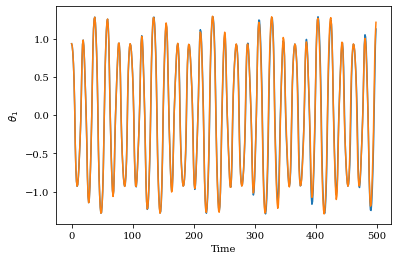

In [90]:
tall = np.array(tall)
plt.plot(new_dataset['x'][:500, 0])
plt.plot(pred_tall[:500, 0])#[:100, 0])
plt.ylabel(r'$\theta_1$')
plt.xlabel('Time')

In [80]:
jnp.max(jax.vmap(kinetic_energy, 0, 0)(new_dataset['x'][:]))

DeviceArray(16.890951, dtype=float32)

In [81]:
jnp.max(jnp.abs(jax.vmap(potential_energy, 0, 0)(new_dataset['x'][:])))

DeviceArray(29.397213, dtype=float32)

We set the scale of the system as the max potential energy of the double
pendulum:

$9.8\times1\times1 + 9.8\times1\times2=29.4$

(-0.06, 0.01)

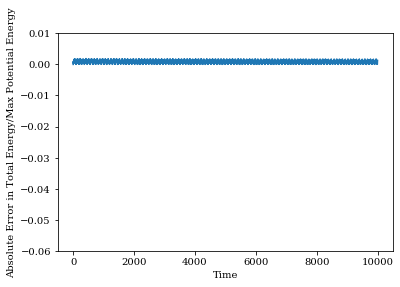

In [85]:
total_true_energy = (
    jax.vmap(kinetic_energy, 0, 0)(new_dataset['x'][:]) + \
    jax.vmap(potential_energy, 0, 0)(new_dataset['x'][:])
)
total_predicted_energy = (
    jax.vmap(kinetic_energy, 0, 0)(pred_tall[:]) + \
    jax.vmap(potential_energy, 0, 0)(pred_tall[:])
)

scale=29.4

# translation = jnp.min(total_true_energy) + 1
# total_true_energy -= translation
# total_predicted_energy -= translation

plt.plot(
    jnp.abs(total_predicted_energy-total_true_energy)/scale
)

plt.ylabel('Absolute Error in Total Energy/Max Potential Energy')
plt.xlabel('Time')
plt.ylim(-0.06, 0.01)

In [146]:
rng = jax.random.PRNGKey(int(1e9))

In [147]:
batch_data = get_derivative_dataset(rng)[0][:100000], get_derivative_dataset(rng)[1][:100000]
print(batch_data[0].shape)

(100000, 4)


In [148]:
loss(best_params, batch_data, 0.0)/len(batch_data[0])

DeviceArray(0.06889821, dtype=float32)

In [126]:
# np.save('lnn_dblpend_energy.npy', total_predicted_energy)
# np.save('lnn_dblpend_prediction.npy', pred_tall)

Let's compare:

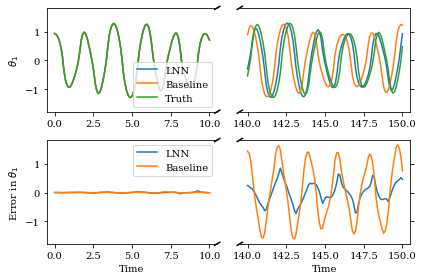

In [149]:

tall = np.array(tall)
fig, ax = plt.subplots(2, 2, sharey=True)


for i in range(2):

    if i == 1:
        start = 1400
        end = 1500
    if i == 0:
        start = 0
        end = 100
        
    dom = np.linspace(start/10, end/10, num=end-start)
    ax[0, i].plot(dom, pred_tall[start:end, 0], label='LNN')#[:100, 0])
    ax[0, i].plot(dom, pred_tall_b[start:end, 0], label='Baseline')#[:100, 0])
    ax[0, i].plot(dom, new_dataset['x'][start:end, 0], label='Truth')
    # ax[0].set_xlabel('Time')
    ax[1, i].plot(dom, -new_dataset['x'][start:end, 0] + pred_tall[start:end, 0],
              label='LNN')#[:100, 0])
    ax[1, i].plot(dom, -new_dataset['x'][start:end, 0] + pred_tall_b[start:end, 0],
              label='Baseline')#[:100, 0])
    if i == 0:
        ax[0, i].set_ylabel(r'$\theta_1$')
        ax[1, i].set_ylabel(r'Error in $\theta_1$')
    
    ax[1, i].set_xlabel('Time')
    if i == 0:
        ax[0, i].legend()
        ax[1, i].legend()
    

for i in range(2):
    ax[i, 0].spines['right'].set_visible(False)
    ax[i, 1].spines['left'].set_visible(False)
#     ax[i, 0].yaxis.tick_left()
#     ax[i, 0].tick_params(labelright='off')
    ax[i, 1].yaxis.tick_right()

for i in range(2):
    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax[i, 0].transAxes, color='k', clip_on=False)
    ax[i, 0].plot((1-d,1+d), (-d,+d), **kwargs)
    ax[i, 0].plot((1-d,1+d),(1-d,1+d), **kwargs)
    kwargs.update(transform=ax[i, 1].transAxes)  # switch to the bottom axes
    ax[i, 1].plot((-d,+d), (1-d,1+d), **kwargs)
    ax[i, 1].plot((-d,+d), (-d,+d), **kwargs)

plt.tight_layout()    
plt.savefig('discrepancy_plot.pdf')

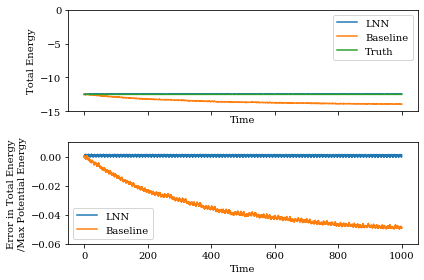

In [150]:
start = 0
end = 9999
dom = np.linspace(start/10, end/10, num=end-start)

scale=29.4

fig, ax = plt.subplots(2, 1, sharex=True)
# translation = jnp.min(total_true_energy) + 1
# total_true_energy -= translation
# total_predicted_energy -= translation

ax[0].plot(
    dom,
    (total_predicted_energy),
    label='LNN'
)
ax[0].plot(
    dom,
    (total_predicted_energy_b),
    label='Baseline'
)
ax[0].plot(
    dom,
    (total_true_energy),
    label='Truth'
)
ax[0].set_ylabel('Total Energy')
ax[0].set_xlabel('Time')
ax[0].set_ylim(-15, 0)
ax[0].legend()

ax[1].plot(
    dom,
    (total_predicted_energy-total_true_energy)/scale,
    label='LNN'
)
ax[1].plot(
    dom,
    (total_predicted_energy_b-total_true_energy)/scale,
    label='Baseline'
)
ax[1].set_ylabel('Error in Total Energy\n/Max Potential Energy')
ax[1].set_xlabel('Time')
ax[1].set_ylim(-0.06, 0.01)
ax[1].legend()


plt.tight_layout()    
plt.savefig('energy_discrepancy_plot.pdf')

In [16]:
best_loss = np.inf
best_params = None

In [ ]:
for _i in range(1000):
    print('Running', _i)
    print('Cur best', str(best_loss))

    init_random_params, nn_forward_fn = extended_mlp(args)
    import HyperparameterSearch
    HyperparameterSearch.nn_forward_fn = nn_forward_fn
    _, init_params = init_random_params(rng+1, (-1, 4))
    rng += 1
    model = (nn_forward_fn, init_params)
    opt_init, opt_update, get_params = optimizers.adam(3e-4)##lambda i: jnp.select([i<10000, i>= 10000], [args.lr, args.lr2]))
    opt_state = opt_init(init_params)
    from jax.tree_util import tree_flatten
    from HyperparameterSearch import make_loss, train
    loss = make_loss(args)
    from copy import deepcopy as copy
    train(args, model, data, rng);
    from jax.tree_util import tree_flatten

    @jax.jit
    def update_derivative(i, opt_state, batch, l2reg):
        params = get_params(opt_state)
        param_update = jax.grad(loss, 0)(params, batch, l2reg)
        leaves, _ = tree_flatten(param_update)
        infinities = sum((~jnp.isfinite(param)).sum() for param in leaves)

        def true_fun(x):
            #No introducing NaNs.
            return opt_update(i, param_update, opt_state), params

        def false_fun(x):
            #No introducing NaNs.
            return opt_state, params

        return jax.lax.cond(infinities==0, 0, true_fun, 0, false_fun)


    best_small_loss = np.inf
    (nn_forward_fn, init_params) = model
    data = {k: jax.device_put(v) for k,v in data.items()}
    iteration = 0
    train_losses, test_losses = [], []
    lr = args.lr
    opt_init, opt_update, get_params = optimizers.adam(lr)
    opt_state = opt_init(init_params)
    bad_iterations = 0
    offset = 0
    
    while iteration < 20000:
        iteration += 1
        rand_idx = jax.random.randint(rng, (args.batch_size,), 0, len(data['x']))
        rng += 1

        batch = (data['x'][rand_idx], data['dx'][rand_idx])
        opt_state, params = update_derivative(iteration+offset, opt_state, batch, args.l2reg)
        small_loss = loss(params, batch, 0.0)

        new_small_loss = False
        if small_loss < best_small_loss:

            best_small_loss = small_loss
            new_small_loss = True
        
        if jnp.isnan(small_loss).sum() or new_small_loss or (iteration % 500 == 0) or (iteration < 1000 and iteration % 100 == 0):
            params = get_params(opt_state)
            train_loss = loss(params, (data['x'], data['dx']), 0.0)/len(data['x'])
            train_losses.append(train_loss)
            test_loss = loss(params, (data['test_x'], data['test_dx']), 0.0)/len(data['test_x'])
            test_losses.append(test_loss)
            
            if iteration >= 1000 and test_loss > 1.5:
                #Only good seeds allowed!
                break

            if test_loss < best_loss:
                best_loss = test_loss
                best_params = copy(params)
                bad_iterations = 0
                offset += iteration
                iteration = 0 #Keep going since this one is so good!

            if jnp.isnan(test_loss).sum():
                break
                lr = lr/2
                opt_init, opt_update, get_params = optimizers.adam(lr)
                opt_state = opt_init(best_params)
                bad_iterations = 0

            print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")

        bad_iterations += 1
    
    import pickle as pkl
    if best_loss < np.inf:
        pkl.dump({'params': best_params, 'args': args},
             open('params_for_loss_{}_nupdates=1.pkl'.format(best_loss), 'wb'))

Running 0
Cur best 0.5416298
iteration=1, train_loss=3.281229, test_loss=3.362365
iteration=2, train_loss=3.338815, test_loss=3.414896
iteration=3, train_loss=3.173423, test_loss=3.245358
iteration=5, train_loss=2.876028, test_loss=2.953962
iteration=8, train_loss=2.617690, test_loss=2.711931
iteration=12, train_loss=2.461916, test_loss=2.569056
iteration=14, train_loss=2.420607, test_loss=2.529519
iteration=16, train_loss=2.393510, test_loss=2.502541
iteration=24, train_loss=2.345873, test_loss=2.449337
iteration=69, train_loss=2.283767, test_loss=2.380207
iteration=71, train_loss=2.279208, test_loss=2.375960
iteration=100, train_loss=2.052558, test_loss=2.182241
iteration=126, train_loss=2.150693, test_loss=2.242196
iteration=138, train_loss=2.043466, test_loss=2.179271
iteration=139, train_loss=2.103001, test_loss=2.250430
iteration=159, train_loss=1.884455, test_loss=2.035448
iteration=200, train_loss=2.981948, test_loss=3.082102
iteration=300, train_loss=2.960814, test_loss=3.0604

In [19]:
import importlib

In [22]:
import lnn

In [24]:
importlib.reload(lnn)

<module 'lnn' from '../lnn.py'>

In [25]:
from lnn import lagrangian_eom_rk4

In [236]:
loss(best_params, (data['test_x'], data['test_dx']), 0.0)/len(data['test_x'])

DeviceArray(1.8673568, dtype=float32)

In [ ]:
best_loss